### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between demanded magnetic field between current configuration

In [31]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Using cpu


In [32]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
load_file_num = 1460
train_file_num = 100
grid_size = 21
data = ReadCurrentAndField (foldername,filepattern, load_file_num)


data=data.reshape(load_file_num,grid_size,grid_size,grid_size,18)
mask = torch.cat((torch.ones(1,1,1,1,12),1e3*torch.ones(1,1,1,1,6)), dim=4)
# position unit mm, B field unit mT, Current unit Ampere
data = mask*data

sparsity = 4

Position_Bfield =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,12:].reshape(-1,6) 
Current = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:12].reshape(-1,12) 

print(np.abs(Current).mean())
print(data.shape)
print('position Bfield shape', Position_Bfield.shape)
print('Current shape', Current.shape)


tensor(7.6044)
torch.Size([1460, 21, 21, 21, 18])
position Bfield shape torch.Size([21600, 6])
Current shape torch.Size([21600, 12])


In [36]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop_v2 import train_ANN
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray, os
import torch.nn.functional as F

# construct dataset
dataset = eMNS_Dataset(
    x=Position_Bfield,
    y=Current
)

# split the dataset to train, validation, test
train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

# normailzation
extremes = dataset.train_norm_ANN(train_indices = train_set.indices, boundary_index=3)

###############################################
# Config the neural network
###############################################
num_input = 6
num_output = 12
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)


model_path = r"./Trained_model/EMS_ANN_v2.pt"
forward_model = torch.load(model_path)['model']
forward_model.eval()

loss_func = lambda current, Bfield, position: F.mse_loss(current, torch.zeros_like(current)) + F.l1_loss(Bfield, forward_model(torch.cat((current, position), axis =1)))


################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 500,
                'lr_max': 1e-3,
                'lr_min': 2.5e-5,
                'batch_size': 128,
                'L2_norm'   : 0,
                'verbose': False,
                'schedule': [],
                'learning_rate_decay': 0.5,
                'num_input'   : num_input,
                'num_output'  : num_output,
                'fc_stages'   : fc_stages,
                'backward'    : True,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'device'      : device,
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'loss_func'   : loss_func,
                'forward_model': forward_model
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    #resource_per_worker = {"CPU":1, "GPU":1}
)

run_config = RunConfig(name="EMS_ANN_backward_v2", storage_path= "~/ray_results",checkpoint_config=CheckpointConfig(num_to_keep=1))

# def train_loop_per_worker(params):
#     train_GM(train_set=train_set, valid_set=valid_set,  device=device, config=params)

trainer = TorchTrainer(
    train_loop_per_worker = train_ANN,
    train_loop_config = train_loop_config,
    scaling_config = scaling_config,
    run_config = run_config,

)
result = trainer.fit()



(TorchTrainer pid=24134) Started distributed worker processes: 
(TorchTrainer pid=24134) - (ip=192.168.8.117, pid=24186) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=24186) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=24186) Epoch 0, Iteration 152, loss = 0.0997
(RayTrainWorker pid=24186) Got rmse 0.034800074994564056


(RayTrainWorker pid=24186) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_backward_v2/TorchTrainer_3fc45_00000_0_2024-04-17_15-22-29/checkpoint_000000)


(RayTrainWorker pid=24186) Got rmse 0.034974467009305954
(RayTrainWorker pid=24186) 
(RayTrainWorker pid=24186) Epoch 1, Iteration 304, loss = 0.0993
(RayTrainWorker pid=24186) Got rmse 0.02942798286676407
(RayTrainWorker pid=24186) Got rmse 0.02953011356294155
(RayTrainWorker pid=24186) 
(RayTrainWorker pid=24186) Epoch 2, Iteration 456, loss = 0.0947
(RayTrainWorker pid=24186) Got rmse 0.028227800503373146
(RayTrainWorker pid=24186) Got rmse 0.028296515345573425
(RayTrainWorker pid=24186) 
(RayTrainWorker pid=24186) Epoch 3, Iteration 608, loss = 0.0864
(RayTrainWorker pid=24186) Got rmse 0.02714441902935505
(RayTrainWorker pid=24186) Got rmse 0.027191990986466408
(RayTrainWorker pid=24186) 
(RayTrainWorker pid=24186) Epoch 4, Iteration 760, loss = 0.0866
(RayTrainWorker pid=24186) Got rmse 0.02639535814523697
(RayTrainWorker pid=24186) Got rmse 0.026419494301080704
(RayTrainWorker pid=24186) 
(RayTrainWorker pid=24186) Epoch 5, Iteration 912, loss = 0.0918
(RayTrainWorker pid=24186)

(RayTrainWorker pid=24186) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_backward_v2/TorchTrainer_3fc45_00000_0_2024-04-17_15-22-29/checkpoint_000001)
2024-04-17 15:26:56,631	INFO tune.py:1042 -- Total run time: 267.09 seconds (267.02 seconds for the tuning loop).


In [37]:
from torchsummary import summary
summary(fc_network, (1,6))
for param_tensor in fc_network.state_dict():
    print(param_tensor, '\t', fc_network.state_dict()[param_tensor].size())

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 12]                  --
|    └─NN_stages: 2-1                    [-1, 100]                 --
|    |    └─Sequential: 3-1              [-1, 100]                 700
|    └─NN_stages: 2-2                    [-1, 50]                  --
|    |    └─Sequential: 3-2              [-1, 50]                  5,050
|    └─NN_stages: 2-3                    [-1, 25]                  --
|    |    └─Sequential: 3-3              [-1, 25]                  1,275
|    └─Linear: 2-4                       [-1, 12]                  312
Total params: 7,337
Trainable params: 7,337
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
total_net.0.net.0.fc.weight 	 torch.Size([100, 6])
total_net.0.net.0.fc.bias 	 torch.Size([100])
total_net.1.net.0.fc.weight 	 torch.Size([50, 100])

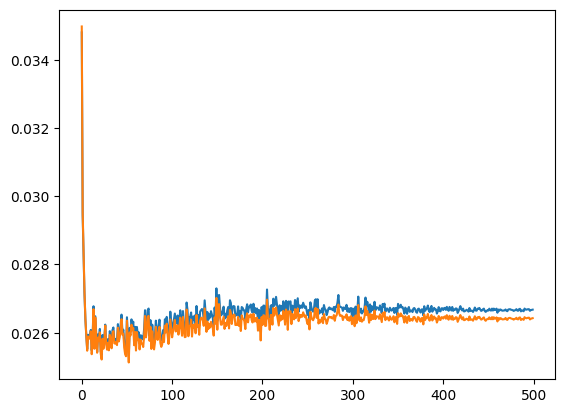

In [38]:
from utils import plot_ray_results
plot_ray_results(results=result, metrics_names = ['rmse_val','rmse_train'])

In [39]:
checkpoint_data = torch.load(os.path.join(result.checkpoint.path,"model.pt"))

model_path = r"./Trained_model/EMS_ANN_backward_v2.pt"
torch.save(checkpoint_data, model_path)

## Test dataset performance

In [41]:
# position unit mm, current unit Ampere, B field unit mT
sparsity = 10
Position_Bfield_test =data[train_file_num:, ::sparsity, ::sparsity, ::sparsity, :6].reshape(-1,6) 

Current_test = data[train_file_num:, ::sparsity, ::sparsity, ::sparsity,:12].reshape(-1,12)

num_sample = Position_Bfield_test.shape[0]
print('position Bfield shape', Position_Bfield_test.shape)
print('Current shape', Current_test.shape)

# construct dataset
test_set = eMNS_Dataset(
    x=Position_Bfield_test,
    y=Current_test
)
test_set.test_norm_ANN(extremes=extremes, boundary_index=3)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=train_loop_config['batch_size'],
    shuffle=False)


position Bfield shape torch.Size([36720, 6])
Current shape torch.Size([36720, 12])


In [48]:
data[train_file_num:, ::sparsity, ::sparsity, ::sparsity, :6].shape

torch.Size([1360, 3, 3, 3, 6])

In [46]:
from utils import predict_check_rmse_ANN, check_rmse_ANN
from Training_loop_v2 import construct_model_ANN 

model_path = r"./Trained_model/EMS_ANN_backward_v2.pt"
backward_model = torch.load(model_path)['model']

prediction, rmse, mse, Rsquare = predict_check_rmse_ANN(test_loader, backward_model, config=train_loop_config)
# check_rmse_ANN(test_loader, backward_model, config=train_loop_config)

Got rmse 6.301229000091553


In [53]:
np.ceil(21/10)

3.0

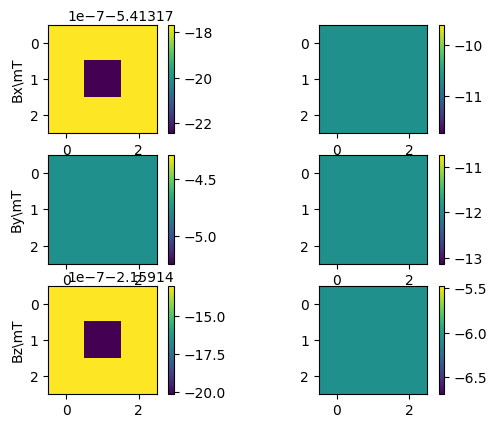

In [56]:
import matplotlib.pyplot as plt
import numpy as np
grid_test = int(np.ceil(grid_size/sparsity))
B_est = prediction.reshape(-1, grid_test, grid_test, grid_test, 3)
Bfield_test = Position_Bfield_test[:,3:].reshape(-1, grid_test, grid_test, grid_test, 3)

current_index=3
z_plane_index= 2
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est[current_index,:,:,z_plane_index,i-1])    
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_test[current_index,:,:,z_plane_index,i-1])
    plt.colorbar()
plt.show()

In [1]:
import numpy as np 
A = np.arange(21)
print(A[::4])
print(A[::1])

[ 0  4  8 12 16 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [27]:
A = torch.arange(3) + 0.0
B = A.reshape(1,3)
print(F.mse_loss(B, torch.zeros_like(B)))
print(torch.linalg.norm(B))

tensor(1.6667)
tensor(2.2361)


In [28]:
np.sqrt(5)

2.23606797749979